In [16]:
import ExonExonData as eed
import pathlib
cwd = pathlib.Path.cwd()
import pandas
import numpy
import pickle
import random
from Heatmaps import heat_embedding
from Heatmaps import heatmapv2 as heatmap
from Heatmaps import _undigitize_seq as undigit
from Heatmaps import _reorder_frame as reorder_frame

import pickle
import matplotlib.pyplot as plt
import GeneClass as Gene
import random
import Heatmaps as hm
from typing import Tuple
from MomentCalculations import moments_v2
from MomentCalculations import moments
from MomentCalculations import _unrenormalize
from MomentCalculations import multiple_species_plots
from MomentCalculations import moments_v3

In [2]:
# data_file = cwd.parent / "Data_Files" / "Primates" / "Genetics" / "Homo_sapiens" / "Cleaned_Data" / "Data_Set_2_frame.pkl"
# transform = numpy.log2
transform = None

# data_file = cwd / "TE_Images_ForPaper" / "Dict" / "Seq_For_Images_n100000_minLength12.pkl"
# with open(data_file, "rb") as file:
#     data = pickle.load(file)

# print(data)

k = 6
# colors: list = ['darkred', 'orangered', 'green', 'lime']
colors: list = ['green', 'orange', 'orangered', 'red']
bounds: list = [0, 0.452, 1.45, 2.36, 3.2] # 0.98


In [3]:
def heat_dataset(source_data: pathlib.Path or pandas.DataFrame, length: int = 12, *args, **kwargs) -> pandas.DataFrame:
    '''
    I have lost how I originally created the dataset for the heatmaps, so here's a function for doing that.

    This assumes the data is a pickle or a dataframe.

    Except never mind, the frame data will work nicely. I'm just going to use this to filter down to a nice length for the sequences
    '''
    if isinstance(source_data, pathlib.Path):
        source_data: pandas.DataFrame = pandas.read_pickle(source_data)


    source_data["Length"] = source_data["Seq"].apply(lambda x: len(x))
    source_data = source_data[source_data["Length"] >= length]
    source_data = source_data.reset_index() 

    return source_data



In [4]:
source_data = cwd.parent / "Data_Files" / "Primates" / "Genetics" / "Homo_sapiens" / "Cleaned_Data" / "Data_Set_1_frame.pkl"
source_data = heat_dataset(source_data)
# print(source_data["Classificaion"].unique())
# source_data["Classificaion"] = source_data["Classificaion"].astype(pandas.Categorical)
exon_data = source_data[source_data["Classificaion"] == "exon"]
intron_data = source_data[source_data["Classificaion"] == "intron"]


print(exon_data.shape)
print(intron_data.shape)
# source_data["Length"] = source_data[""]
print(source_data.head())

(28255, 5)
(26074, 5)
   index        NCIBName Classificaion  \
0      0  NM_001375617.1          exon   
1      1  NM_001375617.1          exon   
2      2  NM_001375617.1          exon   
3      3  NM_001375617.1          exon   
4      4  NM_001375617.1          exon   

                                                 Seq  Length  
0                              GTCAGTGTGGAGGAGACTGAG      21  
1  TATTCTACCTTGTAAATACTGTTATTTGTATATACTGTAAATGATG...     130  
2  GCCACTGCAGAACAAATTAGACTTGCACAGATGATTTCGGACCATA...      78  
3  TTGATTGATATTACAGGCAAGAACCAGGATGAATGTGTGATTGCTT...     111  
4  CATTCCTGGGAGATGGTCGGGAAGAAGAAGGGAGTCTCAGGCCAGA...     202  


In [5]:
source_data["OG_Seq"] = source_data["Seq"]

In [6]:
source_data["Seq"] = source_data["OG_Seq"].apply(lambda x: "".join(random.sample(x, len(x))))

In [7]:
print(source_data.head())

   index        NCIBName Classificaion  \
0      0  NM_001375617.1          exon   
1      1  NM_001375617.1          exon   
2      2  NM_001375617.1          exon   
3      3  NM_001375617.1          exon   
4      4  NM_001375617.1          exon   

                                                 Seq  Length  \
0                              GGGAACAAGGTATGTGGTGGC      21   
1  GTCGTGGCTTCCTTACTCCGGACAACATTTAAGCACAACAAAGGAA...     130   
2  TTTTGGCGTGAAGACGGATAAAATTCGAGTCGCTCGTGATAGAGAT...      78   
3  AGTAAATTAACTGTGCCCTCGATGCTTGGAGTATGCCCTGATAGCT...     111   
4  TGAAAGCAGGCATGGGCGCCGCAGCTAGTACTGGAGAAGGTGACGG...     202   

                                              OG_Seq  
0                              GTCAGTGTGGAGGAGACTGAG  
1  TATTCTACCTTGTAAATACTGTTATTTGTATATACTGTAAATGATG...  
2  GCCACTGCAGAACAAATTAGACTTGCACAGATGATTTCGGACCATA...  
3  TTGATTGATATTACAGGCAAGAACCAGGATGAATGTGTGATTGCTT...  
4  CATTCCTGGGAGATGGTCGGGAAGAAGAAGGGAGTCTCAGGCCAGA...  


Creates the heat embedding dictionaries.

In [8]:
_, exon, intron, _, _, exon_max, exon_min, intron_max, intron_min = heat_embedding(source_data,
                                                                                    # n = n,
                                                                                    # k_m = k, k_p = k,
                                                                                    just_import = True,
                                                                                    log_transform = transform)  # Just import is turned on because I have one dictionary with all the data. I'll use that one set for all the images from now on. Just makes things a little faster and easier.


Saving them for later even though I'm going to use the info out of the previous function to generate the heatmaps and the moments.

In [9]:
exon_frame = reorder_frame(pandas.DataFrame(exon), transpose = True)
intron_frame = reorder_frame(pandas.DataFrame(intron), transpose = True)

dig_labels = list(exon_frame.columns)
# seq_labels = [undigit(dig_seq) for dig_seq in dig_labels]
new_cols = {dig_seq:undigit(dig_seq) for dig_seq in dig_labels}
exon_frame = exon_frame.rename(columns=new_cols, index=new_cols)
intron_frame = intron_frame.rename(columns=new_cols, index=new_cols)

# print(exon_frame)

# with open(cwd / "TE_Images_ForPaper" / "Dict" / "Fixed_Exon_6mer.pkl", "wb") as file:
#     pickle.dump(exon, file)

# with open(cwd / "TE_Images_ForPaper" / "Dict" / "Fixed_Intron_6mer.pkl", "wb") as file:
#     pickle.dump(intron, file)


In [10]:
print(exon_frame)

           AAAAAA     AAAAAG     AAAAAT    AAAAAC     AAAAGA    AAAAGG  \
CCCCCC   0.000000   3.928623   0.000000  1.964312   0.000000  1.964312   
CCCCCT   0.000000   0.000000   0.000000  0.000000   1.964312  0.000000   
CCCCCG   0.000000   1.964312   0.000000  0.000000   0.000000  0.000000   
CCCCCA   0.000000   1.964312   1.964312  0.000000   0.000000  0.000000   
CCCCTC   0.000000   0.000000   0.000000  0.000000   3.928623  1.964312   
...           ...        ...        ...       ...        ...       ...   
AAAAGA  19.643115   9.821558   9.821558  9.821558   5.892935  0.000000   
AAAAAC   7.857246   5.892935   7.857246  3.928623   5.892935  1.964312   
AAAAAT   7.857246  13.750181  11.785869  7.857246   3.928623  1.964312   
AAAAAG  27.500361   7.857246   9.821558  1.964312   9.821558  9.821558   
AAAAAA  15.714492  15.714492  15.714492  9.821558  11.785869  3.928623   

           AAAAGT     AAAAGC     AAAATA     AAAATG  ...    CCCCGT    CCCCGC  \
CCCCCC   1.964312   1.964312   0

In [11]:
print(intron_frame)

           AAAAAA    AAAAAG     AAAAAT    AAAAAC    AAAAGA    AAAAGG  \
CCCCCC   0.977153  0.977153   0.977153  0.488576  1.465729  0.488576   
CCCCCT   0.000000  0.000000   0.488576  1.465729  0.977153  0.488576   
CCCCCG   0.977153  0.488576   0.000000  0.000000  0.977153  0.000000   
CCCCCA   0.000000  0.488576   1.465729  0.488576  0.000000  0.000000   
CCCCTC   1.465729  0.000000   0.488576  0.488576  0.488576  0.000000   
...           ...       ...        ...       ...       ...       ...   
AAAAGA   6.840069  3.908611   7.328645  2.931458  7.328645  0.977153   
AAAAAC   4.885764  3.420035   4.885764  3.908611  1.465729  2.442882   
AAAAAT   9.282951  5.862916  11.237256  4.397187  3.420035  5.862916   
AAAAAG   5.862916  2.931458   5.862916  4.397187  4.885764  2.931458   
AAAAAA  11.237256  1.954305  15.634444  2.442882  3.908611  2.442882   

          AAAAGT    AAAAGC     AAAATA    AAAATG  ...    CCCCGT    CCCCGC  \
CCCCCC  0.000000  2.442882   0.977153  0.488576  ...  2.442

In [12]:
dicts_shuffled = cwd / "Dicts_Shuffled"
dicts_shuffled.mkdir(parents = True, exist_ok = True)

exon_frame.to_pickle(dicts_shuffled / "Exon_6mer.pkl")
intron_frame.to_pickle(dicts_shuffled / "Intron_6mer.pkl")

Output file to
	d:\Coding\Thesis\FractalDimension\TE_Images_ForPaper\Heatmaps\EA\Shuffled_Exon.png
Output file to
	d:\Coding\Thesis\FractalDimension\TE_Images_ForPaper\Heatmaps\EA\Shuffled_Intron.png


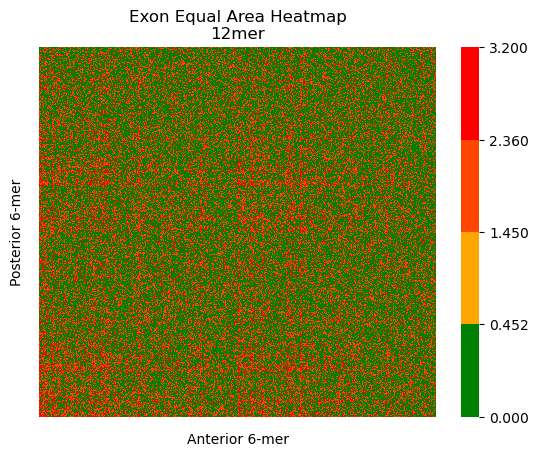

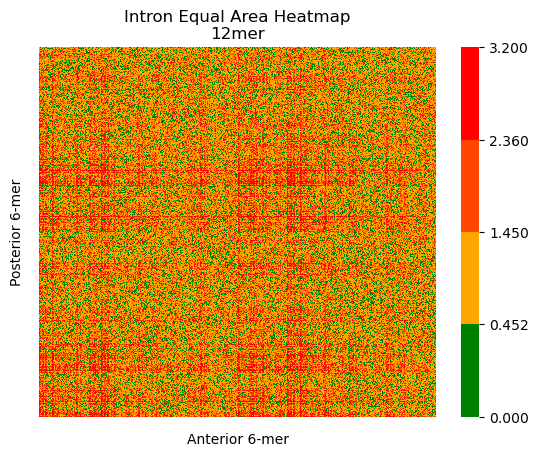

In [13]:
heatmap(exon, colors = colors, bounds = bounds, 
        x_title = f"Anterior {k}-mer", y_title = f"Posterior {k}-mer",
        title = f"Exon Equal Area Heatmap\n{2*k}mer", fileoutput = cwd / "TE_Images_ForPaper" / "Heatmaps" / "EA" / f"Shuffled_Exon.png")
heatmap(intron, colors = colors, bounds = bounds, 
        x_title = f"Anterior {k}-mer", y_title = f"Posterior {k}-mer",
        title = f"Intron Equal Area Heatmap\n{2*k}mer", fileoutput = cwd / "TE_Images_ForPaper" / "Heatmaps" / "EA" / f"Shuffled_Intron.png")


In [14]:
step = 100
max_n = 3
min_n = 0.5
xticks = {0.5: 0.5, 1.0: 1.0, 1.5: 1.5, 2.0: 2.0, 2.5: 2.5, 3.0: 3.0}
ms = [n / step for n in range(int(step*(min_n)), int(step*max_n) + 1)]
title = f"E v I log w/N divided"

In [17]:
with open(cwd / "Dicts_Shuffled" / "Exon_6mer.pkl", "rb") as file:
    shuffled_exon_data: pandas.DataFrame = pickle.load(file)

shuffled_exon_data.to_pickle(cwd / "Dicts_Shuffled" / "Exon_6mer_nLT.pkl")
shuffled_exon_data = _unrenormalize(shuffled_exon_data, 12, log2=False)
print(shuffled_exon_data)
# fixed_data = fixed_data / 4**12  # I think we were supposed to do this.

shuffled_exon_data.to_pickle(cwd / "Dicts_Shuffled" / "Exon_6mer.pkl")

              AAAAAA        AAAAAG        AAAAAT        AAAAAC        AAAAGA  \
CCCCCC  0.000000e+00  2.341642e-07  0.000000e+00  1.170821e-07  0.000000e+00   
CCCCCT  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  1.170821e-07   
CCCCCG  0.000000e+00  1.170821e-07  0.000000e+00  0.000000e+00  0.000000e+00   
CCCCCA  0.000000e+00  1.170821e-07  1.170821e-07  0.000000e+00  0.000000e+00   
CCCCTC  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  2.341642e-07   
...              ...           ...           ...           ...           ...   
AAAAGA  1.170821e-06  5.854104e-07  5.854104e-07  5.854104e-07  3.512463e-07   
AAAAAC  4.683284e-07  3.512463e-07  4.683284e-07  2.341642e-07  3.512463e-07   
AAAAAT  4.683284e-07  8.195746e-07  7.024925e-07  4.683284e-07  2.341642e-07   
AAAAAG  1.639149e-06  4.683284e-07  5.854104e-07  1.170821e-07  5.854104e-07   
AAAAAA  9.366567e-07  9.366567e-07  9.366567e-07  5.854104e-07  7.024925e-07   

              AAAAGG        AAAAGT     

In [18]:
print(shuffled_exon_data)

              AAAAAA        AAAAAG        AAAAAT        AAAAAC        AAAAGA  \
CCCCCC  0.000000e+00  2.341642e-07  0.000000e+00  1.170821e-07  0.000000e+00   
CCCCCT  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  1.170821e-07   
CCCCCG  0.000000e+00  1.170821e-07  0.000000e+00  0.000000e+00  0.000000e+00   
CCCCCA  0.000000e+00  1.170821e-07  1.170821e-07  0.000000e+00  0.000000e+00   
CCCCTC  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  2.341642e-07   
...              ...           ...           ...           ...           ...   
AAAAGA  1.170821e-06  5.854104e-07  5.854104e-07  5.854104e-07  3.512463e-07   
AAAAAC  4.683284e-07  3.512463e-07  4.683284e-07  2.341642e-07  3.512463e-07   
AAAAAT  4.683284e-07  8.195746e-07  7.024925e-07  4.683284e-07  2.341642e-07   
AAAAAG  1.639149e-06  4.683284e-07  5.854104e-07  1.170821e-07  5.854104e-07   
AAAAAA  9.366567e-07  9.366567e-07  9.366567e-07  5.854104e-07  7.024925e-07   

              AAAAGG        AAAAGT     

In [19]:
with open(cwd / "Dicts_Shuffled" / "Intron_6mer.pkl", "rb") as file:
    shuffled_intron_data: pandas.DataFrame = pickle.load(file)

shuffled_intron_data.to_pickle(cwd / "Dicts_Shuffled" / "Intron_6mer_nLT.pkl")
shuffled_intron_data = _unrenormalize(shuffled_intron_data, 12, log2=False)
print(shuffled_intron_data)
# fixed_data = fixed_data / 4**12  # I think we were supposed to do this.

shuffled_intron_data.to_pickle(cwd / "Dicts_Shuffled" / "Intron_6mer.pkl")

              AAAAAA        AAAAAG        AAAAAT        AAAAAC        AAAAGA  \
CCCCCC  5.824284e-08  5.824284e-08  5.824284e-08  2.912142e-08  8.736426e-08   
CCCCCT  0.000000e+00  0.000000e+00  2.912142e-08  8.736426e-08  5.824284e-08   
CCCCCG  5.824284e-08  2.912142e-08  0.000000e+00  0.000000e+00  5.824284e-08   
CCCCCA  0.000000e+00  2.912142e-08  8.736426e-08  2.912142e-08  0.000000e+00   
CCCCTC  8.736426e-08  0.000000e+00  2.912142e-08  2.912142e-08  2.912142e-08   
...              ...           ...           ...           ...           ...   
AAAAGA  4.076999e-07  2.329714e-07  4.368213e-07  1.747285e-07  4.368213e-07   
AAAAAC  2.912142e-07  2.038499e-07  2.912142e-07  2.329714e-07  8.736426e-08   
AAAAAT  5.533070e-07  3.494570e-07  6.697927e-07  2.620928e-07  2.038499e-07   
AAAAAG  3.494570e-07  1.747285e-07  3.494570e-07  2.620928e-07  2.912142e-07   
AAAAAA  6.697927e-07  1.164857e-07  9.318855e-07  1.456071e-07  2.329714e-07   

              AAAAGG        AAAAGT     

In [20]:
print(shuffled_intron_data)

              AAAAAA        AAAAAG        AAAAAT        AAAAAC        AAAAGA  \
CCCCCC  5.824284e-08  5.824284e-08  5.824284e-08  2.912142e-08  8.736426e-08   
CCCCCT  0.000000e+00  0.000000e+00  2.912142e-08  8.736426e-08  5.824284e-08   
CCCCCG  5.824284e-08  2.912142e-08  0.000000e+00  0.000000e+00  5.824284e-08   
CCCCCA  0.000000e+00  2.912142e-08  8.736426e-08  2.912142e-08  0.000000e+00   
CCCCTC  8.736426e-08  0.000000e+00  2.912142e-08  2.912142e-08  2.912142e-08   
...              ...           ...           ...           ...           ...   
AAAAGA  4.076999e-07  2.329714e-07  4.368213e-07  1.747285e-07  4.368213e-07   
AAAAAC  2.912142e-07  2.038499e-07  2.912142e-07  2.329714e-07  8.736426e-08   
AAAAAT  5.533070e-07  3.494570e-07  6.697927e-07  2.620928e-07  2.038499e-07   
AAAAAG  3.494570e-07  1.747285e-07  3.494570e-07  2.620928e-07  2.912142e-07   
AAAAAA  6.697927e-07  1.164857e-07  9.318855e-07  1.456071e-07  2.329714e-07   

              AAAAGG        AAAAGT     

In [21]:
me, mi, mn, uni, _ = moments_v3(cwd / "HS_Dicts_EF_Fixed", ms, min_k=6, N_value = True)

K = 6
		m = 0.5	N = 16777216.0
		m = 0.51	N = 8737708.39987156
		m = 0.52	N = 4666295.220317386
		m = 0.53	N = 2551685.0992082297
		m = 0.54	N = 1426891.7352228423
		m = 0.55	N = 814956.5606571109
		m = 0.56	N = 474860.0484895941
		m = 0.57	N = 281985.8330341041
		m = 0.58	N = 170487.96140090268
		m = 0.59	N = 104849.9103044397
		m = 0.6	N = 65536.00000000009
		m = 0.61	N = 41599.03078782457
		m = 0.62	N = 26795.02272868485
		m = 0.63	N = 17502.07186230314
		m = 0.64	N = 11585.237502960395
		m = 0.65	N = 7766.650997466475
		m = 0.66	N = 5270.1794222466315
		m = 0.67	N = 3617.796446487984
		m = 0.68	N = 2511.1241589963333
		m = 0.69	N = 1761.5243417926727
		m = 0.7	N = 1248.2699819053835
		m = 0.71	N = 893.1860454584129
		m = 0.72	N = 645.0795775461745
		m = 0.73	N = 470.06365576289903
		m = 0.74	N = 345.4737853511545
		m = 0.75	N = 255.9999999999997
		m = 0.76	N = 191.20114709177446
		m = 0.77	N = 143.89086245194235
		m = 0.78	N = 109.07909074285735
		m = 0.79	N = 83.27126499963866
		m

In [22]:
se, si, sn, _, _ = moments_v3(cwd / "Dicts_Shuffled", ms, min_k=6, N_value = True)

K = 6
		m = 0.5	N = 16777216.0
		m = 0.51	N = 8737708.39987156
		m = 0.52	N = 4666295.220317386
		m = 0.53	N = 2551685.0992082297
		m = 0.54	N = 1426891.7352228423
		m = 0.55	N = 814956.5606571109
		m = 0.56	N = 474860.0484895941
		m = 0.57	N = 281985.8330341041
		m = 0.58	N = 170487.96140090268
		m = 0.59	N = 104849.9103044397
		m = 0.6	N = 65536.00000000009
		m = 0.61	N = 41599.03078782457
		m = 0.62	N = 26795.02272868485
		m = 0.63	N = 17502.07186230314
		m = 0.64	N = 11585.237502960395
		m = 0.65	N = 7766.650997466475
		m = 0.66	N = 5270.1794222466315
		m = 0.67	N = 3617.796446487984
		m = 0.68	N = 2511.1241589963333
		m = 0.69	N = 1761.5243417926727
		m = 0.7	N = 1248.2699819053835
		m = 0.71	N = 893.1860454584129
		m = 0.72	N = 645.0795775461745
		m = 0.73	N = 470.06365576289903
		m = 0.74	N = 345.4737853511545
		m = 0.75	N = 255.9999999999997
		m = 0.76	N = 191.20114709177446
		m = 0.77	N = 143.89086245194235
		m = 0.78	N = 109.07909074285735
		m = 0.79	N = 83.27126499963866
		m

In [23]:
me_plots = {"Human": {"data": me, "marker": None}, "Shuffled": {"data": se, "marker": None}}
mi_plots = {"Human": {"data": mi, "marker": None}, "Shuffled": {"data": si, "marker": None}}
# mn = {"Human": {"data": mn, "marker": None}}
mn_plots = None

Species = Human
plotting for 12-mer
Species = Shuffled
plotting for 12-mer


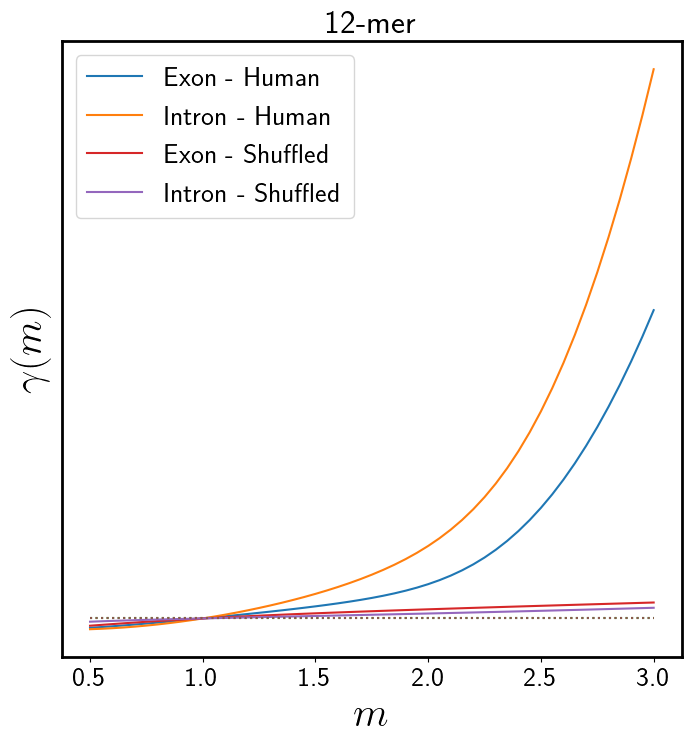

In [24]:
multiple_species_plots(ms, me_plots, mi_plots, mn_plots, uni, cwd / "TE_Images_ForPaper" / "Shuffled", x_ticks = xticks)
